<a href="https://colab.research.google.com/github/mshsu/stat400-sets/blob/main/earthquakes_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Earthquakes Demo

The **exponential distribution** can be used to model time between instances of independent, regularly occuring events. Let's look at an example of this in *real time* US Geological Survey (USGS) earthquakes data from the past 30 days. (More info found [here](https://earthquake.usgs.gov/earthquakes/feed/v1.0/csv.php). This data is updated every minute!) Can we model the time between 5.0+ magnitude earthquakes using the exponential distribution?

## Setup

In [ ]:
!pip install symbulate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 1.5 MB/s eta 0:00:00


In [ ]:
from symbulate import *
import pandas as pd
import matplotlib.pyplot as plt
import warnings

In [ ]:
warnings.filterwarnings("ignore")

## Data

In [ ]:
df_earthquakes = pd.read_csv("https://earthquake.usgs.gov/earthquakes/feed/v1.0/summary/4.5_month.csv")

df_earthquakes

,time,latitude,longitude,depth,mag,magType,nst,gap,dmin,rms,...,updated,place,type,horizontalError,depthError,magError,magNst,status,locationSource,magSource
0,2023-04-18T22:39:29.789Z,-3.8909,101.7144,48.820,4.6,mb,27.0,180.0,1.323,0.98,...,2023-04-18T22:57:16.040Z,"62 km W of Bengkulu, Indonesia",earthquake,6.88,8.599,0.141,15.0,reviewed,us,us
1,2023-04-18T16:51:04.422Z,-7.5040,156.0860,71.662,4.9,mb,51.0,61.0,4.276,0.58,...,2023-04-18T17:22:49.040Z,"106 km NW of Gizo, Solomon Islands",earthquake,9.78,6.948,0.087,41.0,reviewed,us,us
2,2023-04-18T16:44:51.884Z,18.0630,145.4028,433.479,4.6,mb,103.0,120.0,4.478,0.81,...,2023-04-18T17:03:41.040Z,"Pagan region, Northern Mariana Islands",earthquake,11.81,8.632,0.038,207.0,reviewed,us,us
3,2023-04-18T15:49:10.013Z,-19.5900,-175.7974,212.430,4.6,mb,45.0,111.0,1.940,0.72,...,2023-04-18T16:46:59.040Z,"153 km W of Pangai, Tonga",earthquake,15.07,6.559,0.094,34.0,reviewed,us,us
4,2023-04-18T10:09:59.284Z,-18.3703,167.3725,10.000,4.9,mb,31.0,81.0,3.631,0.42,...,2023-04-18T10:40:56.040Z,"121 km SW of Port-Vila, Vanuatu",earthquake,4.00,1.908,0.115,24.0,reviewed,us,us
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
383,2023-03-20T11:57:15.555Z,-56.0760,-27.8664,130.997,5.1,mb,67.0,42.0,5.257,0.57,...,2023-03-27T05:42:06.040Z,South Sandwich Islands region,earthquake,8.61,4.050,0.061,87.0,reviewed,us,us
384,2023-03-20T07:08:26.407Z,29.8863,142.4074,10.000,4.9,mb,72.0,134.0,3.907,0.50,...,2023-03-20T07:31:44.040Z,"Izu Islands, Japan region",earthquake,10.21,1.890,0.069,66.0,reviewed,us,us
385,2023-03-20T01:59:22.842Z,35.4550,140.9403,31.285,4.6,mwr,181.0,46.0,2.391,0.68,...,2023-04-03T00:47:19.657Z,"near the east coast of Honshu, Japan",earthquake,7.11,3.930,0.066,22.0,reviewed,us,us
386,2023-03-20T01:36:41.757Z,-32.5401,-179.1416,10.166,4.5,mb,11.0,161.0,3.432,0.20,...,2023-04-02T22:56:10.040Z,south of the Kermadec Islands,earthquake,13.95,5.609,0.222,6.0,reviewed,us,us


## Wrangling

In [ ]:
# Filter to magnitude 5 and above
df_mag5 = df_earthquakes[df_earthquakes["mag"]>=5.5]
# Change the datatype of the time variable from string to something called datetime to make it easier to work with
df_mag5["datetime"] = pd.to_datetime(df_mag5["time"])
# Sort the values by date, with oldest earthquake first
df_mag5 = df_mag5[["datetime", "mag"]].sort_values(by="datetime", ignore_index=True)

# Find the time since the last 5.0+ earthquake for each earthquake except for the first one
time_before = [0] + list(pd.to_numeric(df_mag5["datetime"]))[:-1]
df_mag5["intertime"] = pd.to_numeric(df_mag5["datetime"])-pd.Series(time_before)
df_mag5["intertime_str"] = df_mag5["intertime"].apply(pd.Timedelta)
# Get date and time for each occurrence
df_mag5["date"] = df_mag5["datetime"].dt.date
df_mag5["time"] = df_mag5["datetime"].dt.time
# Filter variables down to the ones we want
df_mag5=df_mag5.iloc[1:][["date", "time", "mag", "intertime", "intertime_str"]]

df_mag5

,date,time,mag,intertime,intertime_str
1,2023-03-21,16:47:23.595000,6.5,54189779000000,0 days 15:03:09.779000
2,2023-03-21,17:38:13.460000,5.5,3049865000000,0 days 00:50:49.865000
3,2023-03-21,20:41:08.161000,5.5,10974701000000,0 days 03:02:54.701000
4,2023-03-22,07:37:01.134000,5.6,39352973000000,0 days 10:55:52.973000
5,2023-03-22,14:16:46.540000,5.5,23985406000000,0 days 06:39:45.406000
6,2023-03-22,16:00:31.218000,6.5,6224678000000,0 days 01:43:44.678000
7,2023-03-22,20:07:44.829000,5.8,14833611000000,0 days 04:07:13.611000
8,2023-03-22,23:31:55.803000,5.6,12250974000000,0 days 03:24:10.974000
9,2023-03-23,00:17:39.688000,5.7,2743885000000,0 days 00:45:43.885000
10,2023-03-24,03:16:57.027000,5.6,97157339000000,1 days 02:59:17.339000


## Rate/Average

In [ ]:
beta = df_mag5["intertime"].mean()
lambd = 1/(beta/(1000000000*60*60*24))

print('Avg Time btwn Occurrences: %s\nRate: %.4f 5.0+ mag earthquakes per day'
      % (pd.Timedelta(beta), lambd))

Avg Time btwn Occurrences: 0 days 16:52:11.201200
Rate: 1.4227 5.0+ mag earthquakes per day


## Exponential Distribution

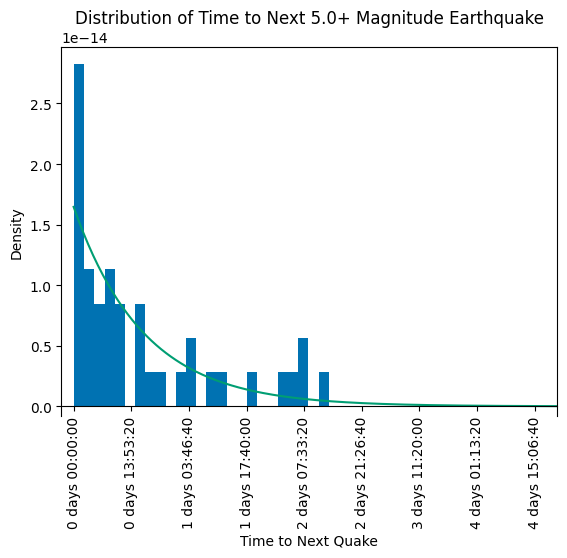

In [ ]:
# Plotting the observed data
df_mag5["intertime"].hist(density=True, bins=25, grid=False)
# Plotting the theoretical distribution
Exponential(rate=1/beta).plot()

# Cosmetic stuff
ax = plt.gca()
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="Time to Next Quake")
plt.title(label="Distribution of Time to Next 5.0+ Magnitude Earthquake")
xticks = [str(pd.Timedelta(i)) for i in ax.get_xticks()]
ax.set_xticklabels(xticks)
plt.xticks(rotation=90)
xlims = ax.get_xlim()
plt.show()

## Poisson Distribution

In [ ]:
# Get frequency of appropriate quakes by date
df_counts = df_mag5["date"].value_counts().to_frame().reset_index().rename(columns={"index": "date", "date": "freq"}).sort_values(by="date", ignore_index=True)

# However, the df_counts we just generated doesn't contain days with 0 quakes.
# We need to fix this by generating rows for dates with 0 quakes.
# First, let's find the start and end dates.
start_date = df_counts['date'].min()
end_date = df_counts['date'].max()

# Change the datatype of existing date data to string (for better merging)
df_counts['date'] = df_counts['date'].astype(str)
# Here we generate a dataframe with all dates
all_dates = pd.DataFrame(pd.date_range(start_date, end_date - pd.Timedelta(days = 1), freq='d')).rename(columns={0: 'date'}).astype(str)
# Here we merge the df_counts with the table with all dates
# Then we fill in 0s for dates with no quakes
df_counts = pd.merge(how='left', left=all_dates, right=df_counts, on='date').fillna(0)
df_counts['freq'] = df_counts['freq'].astype(int)

df_counts

,date,freq
0,2023-03-21,3
1,2023-03-22,5
2,2023-03-23,1
3,2023-03-24,2
4,2023-03-25,0
5,2023-03-26,0
6,2023-03-27,2
7,2023-03-28,1
8,2023-03-29,0
9,2023-03-30,1


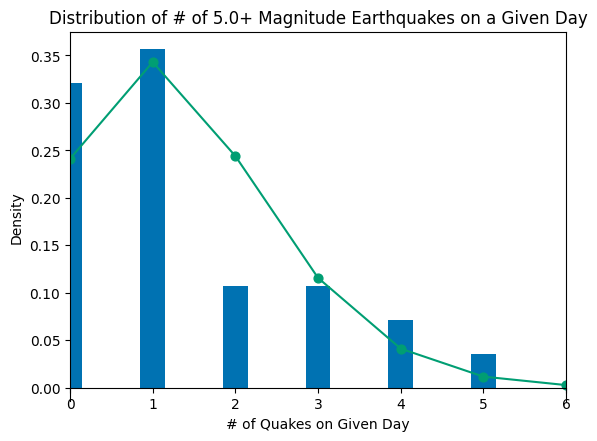

In [ ]:
# This makes it so our histogram bar centers line up with the dots on the theoretical distribution
bin_edges=[i+0.5 for i in list(range(min(df_counts["freq"])-1, max(df_counts["freq"])+1, 1))]

# This is the number of days in our timeframe
t=1
# This is our Poisson parameter mu
mu=lambd*t

# Plotting the observed data
df_counts["freq"].hist(density=True, bins=bin_edges, rwidth=0.3, grid=False)
# Plotting the theoretical distribution
Poisson(mu).plot()

# Cosmetic stuff
plt.ylabel(ylabel="Density")
plt.xlabel(xlabel="# of Quakes on Given Day")
plt.title(label="Distribution of # of 5.0+ Magnitude Earthquakes on a Given Day")
plt.xlim((0,max(df_counts["freq"])+1))
plt.show()